<a href="https://colab.research.google.com/github/37stu37/FFE/blob/master/FFE_numba_Dask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
%%time 
%%capture
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
!pip install memory_profiler

KeyboardInterrupt: ignored

CPU times: user 76.9 ms, sys: 9.08 ms, total: 86 ms
Wall time: 980 ms


In [68]:
# Load the Drive helper and mount
from google.colab import drive
%tensorflow_version 2.x
# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
%%time
import datetime
import glob
from math import sqrt
import os
import matplotlib.pyplot as plt
import bokeh
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.spatial import distance
from shapely.geometry import box
from shapely.geometry import shape
from shapely.geometry import Point
import networkx as nx
from sys import getsizeof
from numba import jit
import dask.dataframe as dd
import dask.array as da
import dask
from dask.distributed import Client
from dask.diagnostics import ProgressBar
%matplotlib inline
%load_ext memory_profiler

pd.options.mode.chained_assignment = None  # default='warn'

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
CPU times: user 1.82 ms, sys: 0 ns, total: 1.82 ms
Wall time: 1.6 ms


In [70]:
client = Client(processes=False)
client

/usr/local/lib/python3.6/dist-packages/distributed/bokeh/core.py:57: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 99] Cannot assign requested address
  warnings.warn('\n' + msg)
/usr/local/lib/python3.6/dist-packages/distributed/deploy/local.py:197: UserWarning: 
Could not launch service 'bokeh' on port 8787. Got the following message:

[Errno 99] Cannot assign requested address
  self.scheduler.start(scheduler_address)


Client Scheduler: inproc://172.28.0.2/3836/28,Cluster Workers: 1 Cores: 2 Memory: 13.66 GB


Set up the path  to data and output

In [71]:
path = '/content/drive/My Drive/05_Sync/FFE/FireNetwork/00_input'
path_output = '/content/drive/My Drive/05_Sync/FFE/FireNetwork/00_output'

!ls "/content/drive/My Drive/05_Sync/FFE/FireNetwork/00_input"
!ls '/content/drive/My Drive/05_Sync/FFE/FireNetwork/00_output/dask_edge_list'

buildings_raw.cpg      buildings_raw_pts.mshp  buildings_raw.shp
buildings_raw.dbf      buildings_raw_pts.prj   buildings_raw.shx
buildings_raw.prj      buildings_raw_pts.shp   GD_wind.csv
buildings_raw_pts.cpg  buildings_raw_pts.shx   source_target.csv
buildings_raw_pts.dbf  buildings_raw.qpj
edge_data.parquet


Create the functions to be used by the algorithm

In [0]:
# wind scenario
def wind_scenario(file_name):
    # wind scenario conditions
    wind_data = pd.read_csv(os.path.join(path, file_name))
    i = np.random.randint(0, wind_data.shape[0])
    w = wind_data.iloc[i, 2]
    d = wind_data.iloc[i, 1]
    b = wind_data.iloc[i, 3]
    # wind direction
    wind_bearing_max = b + 45
    wind_bearing_min = b - 45
    if b == 360:
        wind_bearing_max = 45
    if b <= 0:  # should not be necessary
        wind_bearing_min = 0
    if b == 999:
        wind_bearing_max = 999
        wind_bearing_min = 0
    
    return wind_bearing_max, wind_bearing_min, d

In [0]:
# create ignitions
def ignitions(edges):
    # add random column
    edges['rng'] = np.random.uniform(0, 1, size=len(edges))
    # fires_src = dd.concat(edges, dd.from_dask_array(x))
    # filter on random column
    fires_src = edges[edges.rng > edges.IgnProb_bl]

    fires['step'] = 0
    fires['scenario'] = scenario

    return fires_src

In [0]:
# burned assets
def record_burnt_assets(burn, fires):
  data = [fires, burn]
  burnt = pd.concat(data, axis=0)
  return burnt

In [0]:
# conditions of fire propagation
def conditions_spread(fires,burn,wind_bearing_max,wind_bearing_min,wind_distance,
                      scenario, step):
    print("list df burn : {}".format(burn.columns))
    # add columns to ddf
    fires['wind_bearing_max'] = wind_bearing_max
    fires['wind_bearing_min'] = wind_bearing_min
    fires['wind_distance'] = wind_distance
    # wind speed -> neighbors selection from wind buffer
    fires = fires[fires.distance < fires.wind_distance]
    # wind direction
    fires = fires[(fires.bearing < fires.wind_bearing_max) & (fires.bearing < fires.wind_bearing_min)]
    # should not be already burnt
    burn_list = list(set(burn.source))
    fires = fires[~fires.source.isin(burn_list)]
    burn_list.append(fires.source)

    fires['step'] = step
    fires['scenario'] = scenario

    BURNED = record_burnt_assets(burn, fires)
    return fires, BURNED

In [0]:
# spreading fire
def new_fires(fires, edges):
  fires_list = list(set(fires.target))
  new_fires = edges[edges.source.isin(fires_list)]
  return new_fires

In [0]:
# run main
def main(number_of_scenarios, edges):
  list_BURNED = []
  # --- SCENARIOS
  print("number of scenarios : {}".format(number_of_scenarios))
  for scenario in range(number_of_scenarios):
      BURNED = pd.DataFrame(columns=['source','target','distance', 'bearing',
                                      'IgnProb_bl', 'scenario', 'step'])
      # BURNED = dd.from_pandas(BURNED, npartitions=1)
      print("--- SCENARIO : {}".format(scenario))
      FIRES = ignitions(EDGES)
      # print("FIRES : {}".format(FIRES.head()))
      if len(FIRES.index) == 0:
          print("no fire")
          continue
      wind_bearing_max, wind_bearing_min, wind_distance = wind_scenario('GD_wind.csv') # no filtering, just adding wind info to dataframe
      # --------- STEPS
      for step in range(len(EDGES)):
          print("--------- STEP : {}".format(step))
          FIRES, BURNED = conditions_spread(FIRES, BURNED, wind_bearing_max, wind_bearing_min, wind_distance,
                                            scenario, step) # filtering
          print("filtered w conditions FIRES : {}".format(FIRES))
          print("BURNED : {}".format(BURNED))
          if len(FIRES.index) == 0:
            print("no more fire")
            break
          FIRES = new_fires(FIRES, edges)
          print("new FIRES : {}".format(FIRES))
          # BURNED = burnt_assets(BURNED, FIRES)
  
      list_BURNED.append(BURNED)

In [0]:
# display network
def display_network(edge_list_dataframe):
    graph = nx.from_pandas_edgelist(edge_list_dataframe, edge_attr=True)
    options = {'node_color': 'red', 'node_size': 50, 'width': 1, 'alpha': 0.4,
               'with_labels': False, 'font_weight': 'bold'}
    nx.draw_kamada_kawai(graph, **options)
    plt.show()
    return graph

peak memory: 841.06 MiB, increment: 0.00 MiB


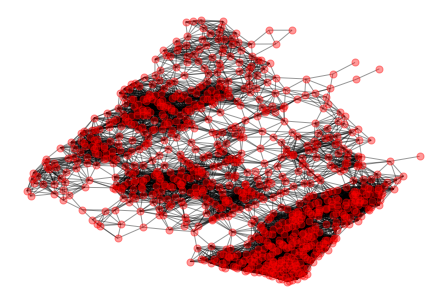

CPU times: user 17.9 s, sys: 746 ms, total: 18.7 s
Wall time: 17.8 s


In [109]:
%%time
%memit
# with ProgressBar():
# load data
# EDGES = dd.read_parquet(os.path.join(path_output, 'dask_edge_list', 'edge_data.parquet'), engine='pyarrow')
EDGES = pd.read_parquet(os.path.join(path_output, 'dask_edge_list', 'edge_data.parquet'), engine='pyarrow')

G = display_network(EDGES)

In [134]:
%%time
%memit
# run main
list_BURN = main(1, EDGES)

peak memory: 841.12 MiB, increment: 0.00 MiB
number of scenarios : 1
--- SCENARIO : 0
--------- STEP : 0
list df burn : Index(['source', 'target', 'distance', 'bearing', 'IgnProb_bl', 'scenario',
       'step'],
      dtype='object')
filtered w conditions FIRES :        source  target   distance  ...  wind_distance  step  scenario
137     27947   28437  11.277230  ...             13     0         0
254     28220   28227   0.000000  ...             13     0         0
263     28221   27900   0.000000  ...             13     0         0
291     28227   28441  12.614658  ...             13     0         0
331     28397   28396   9.328277  ...             13     0         0
...       ...     ...        ...  ...            ...   ...       ...
27044   72638   72639   1.268971  ...             13     0         0
27113   72639   72640   4.271103  ...             13     0         0
27183   72640   72641   3.440096  ...             13     0         0
27195   72641   61144   8.327660  ...         

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
%%time
# check convergence
from itertools import groupby
number_of_burns_per_scenarios = [len(list(group)) for key, group in groupby(scos)]
cumulative_number_of_burns_per_scenarios = list(np.cumsum(number_of_burns_per_scenarios))
scenario_list = list(set(scos))
scenario_list = [x+1 for x in scenario_list]

average_burn_per_scenario = [c / s for c,s in zip(cumulative_number_of_burns_per_scenarios, scenario_list)]

In [0]:
plt.plot(scenario_list, average_burn_per_scenario)